# Practical 3: Convolutional Neural Networks (CNNs)
https://courses.cs.ox.ac.uk/pluginfile.php/14000/course/section/1444/practical3.pdf

In [1]:
import torch
from torchvision import datasets, transforms

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# get MNIST
dataset = datasets.MNIST('./mnist', train=True, download=True, transform=transform)
dataset_train, dataset_valid = torch.utils.data.random_split(dataset, [50000, 10000])
dataset_test = datasets.MNIST('./mnist', train=False, transform=transform)

In [15]:
print(dataset_test.data.shape)
print(len(dataset_train))
print(len(dataset_valid))

torch.Size([10000, 28, 28])
50000
10000


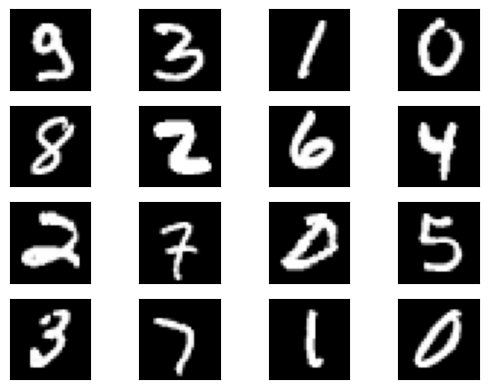

In [2]:
# visualize some images
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(dataset_train[i][0].reshape(28, 28), cmap='Greys_r')

In [3]:
# make the model
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # shape Bx1x28x28
        # guide on page 15: https://arxiv.org/pdf/1603.07285
        self.conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels=25,
            kernel_size=12, 
            stride=2,
            padding="valid"
        )
        
        # Bx25x9x9
        self.conv2 = nn.Conv2d(
            in_channels=25, 
            out_channels=64,
            kernel_size=5, 
            stride=1,
            padding="same"
        )

        # Bx64x9x9
        self.pool = nn.MaxPool2d(2, 2)

        # Bx64x4x4
        self.flat1 = nn.Linear(64*4*4, 1024)
        self.dropout = nn.Dropout(p=0.2)
        self.flat2 = nn.Linear(1024, 10)

    def forward(self, x):
        # print(x.shape)
        x = F.relu(self.conv1(x))
        # print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = torch.flatten(x, 1) # keep the batch dimension?? or is it (1, x)
        # print(x.shape)
        x = F.relu(self.flat1(x))
        x = self.dropout(x)
        x = F.relu(self.flat2(x))
        return x


In [9]:
# make the model
model = CNN()

# get prediction from initial state
# img = dataset_train[0][0]
# print(img.shape)
# model.forward(img)

In [10]:
# training
from tqdm import tqdm
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# make learning curve
losses = []

BATCH_SIZE = 64
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

# for epoch in tqdm(range(3)):
#     running_loss = 0.0
for i, data in tqdm(enumerate(trainloader)):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    # # but labels are just the number so I need to encode it as a one-hot
    # hot_labels = torch.nn.functional.one_hot(labels)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    # print(inputs.shape)
    # print(outputs.shape)
    # print(labels.shape)
    # print(labels)
    # print(hot_labels.shape)
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    losses.append(loss.item())
    # running_loss += loss.item()

print('Finished Training')


782it [01:06, 11.73it/s]

Finished Training


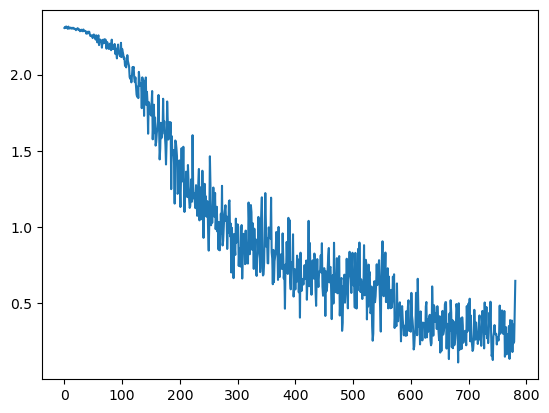

In [11]:
plt.plot(losses)

In [31]:
# save model
PATH = './mnist-net.pt'
torch.save(model.state_dict(), PATH)

In [29]:
# get accuracy
def evaluate(model):
    correct = 0
    total = 0
    model.eval()
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return correct / total


In [30]:
evaluate(model)

0.9782